# Time Series Data Exploration

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.ion()

Plotting defaults:

In [2]:
plt.rc('figure', figsize=(13, 6))
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=13)

Historical San Antonio weather data.

In [3]:
# T(°F) = T(K) × 9/5 - 459.67
def to_fahrenheit(k):
    return k * 9/5 - 459.67

url = "https://gist.githubusercontent.com/ryanorsinger/0ec766c66f4089bdcbc1d4fb294a3394/raw/197c1f0d7b55a45f29437811bc73d9c4ef8af647/sa_temps.csv"
s = pd.read_csv(url, index_col='datetime', parse_dates=True).temp
s = s.dropna()
s = to_fahrenheit(s)
print('Data ranges from {} to {}'.format(s.index.min(), s.index.max()))
s.head()

Data ranges from 2012-10-01 13:00:00 to 2017-11-30 00:00:00


datetime
2012-10-01 13:00:00    61.052000
2012-10-01 14:00:00    61.076568
2012-10-01 15:00:00    61.139294
2012-10-01 16:00:00    61.202020
2012-10-01 17:00:00    61.264747
Name: temp, dtype: float64

In [4]:
type(s)


pandas.core.series.Series

## How do we visualize time series data?

Line plot with time on the x-axis

<AxesSubplot:xlabel='datetime'>

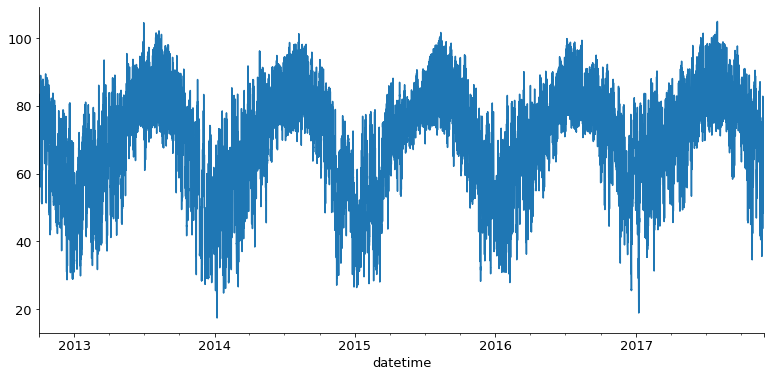

In [5]:
s.plot()

Re-sampling at a longer frequency "smooths" the line

<AxesSubplot:xlabel='datetime'>

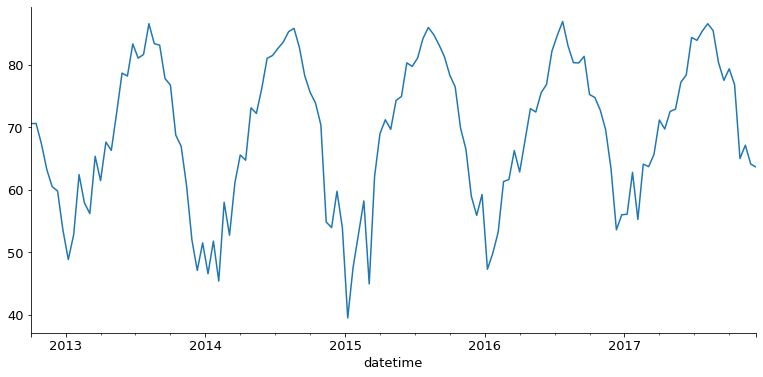

In [6]:
s.resample('2W').mean().plot()

We can combine multiple resampling periods on a single viz:

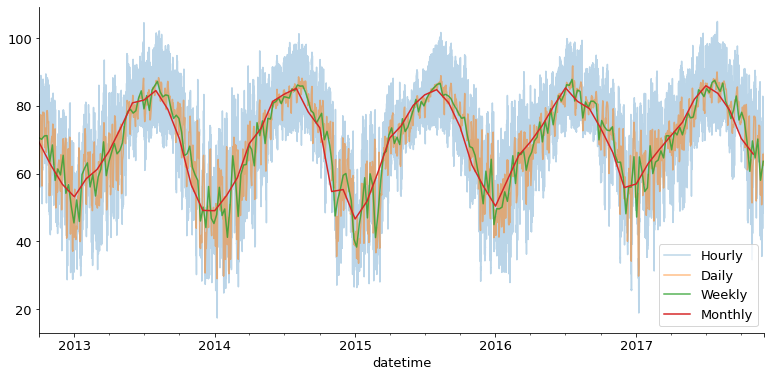

In [7]:
ax = s.plot(alpha=.3, label='Hourly')
s.resample('D').mean().plot(ax=ax, alpha=.5, label='Daily')
s.resample('W').mean().plot(ax=ax, alpha=.8, label='Weekly')
s.resample('M').mean().plot(ax=ax, label='Monthly')
ax.legend()

Treat date components as categorical variables

<div class="alert alert-info">
    <p><strong>Aside: Month and Weekday Ordering</strong></p>
    <p>By default, matplotlib/pandas will sort months and weekdays alphabetically, which is usually not what we want.</p>
    <p>There are several ways to work around this:</p>
    <ul>
        <li>Just use the month (1-12) number or weekday number (1-7)</li>
        <li>Instead of using just the month or weekday, use a leading number and then the name (e.g. 1-Jan, 2-Feb)</li>
        <li>Use a combination of the techniques above, and then re-index the resulting pandas object with more human friendly names</li>
        <li>Use a combination of the techniques above, and then manually adjust the labels with matplotlib</li>
    </ul>
</div>

<AxesSubplot:ylabel='datetime'>

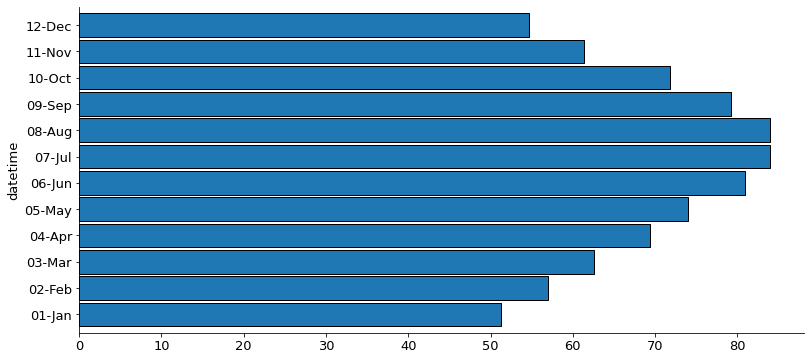

In [8]:
# s.groupby(s.index.month).mean().plot.bar()
# demonstrating one of the above techniques
s.groupby(s.index.strftime('%m-%b')).mean().plot.barh(width=.9, ec='black')

Moving Average

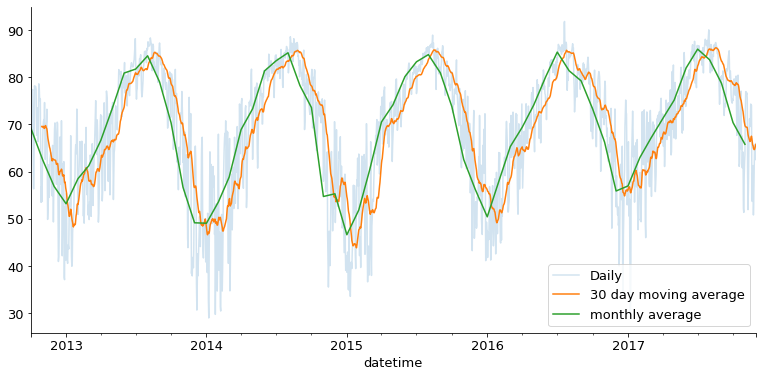

In [9]:
ax = s.resample('D').mean().plot(label='Daily', alpha=.2)
s.resample('D').mean().rolling(30).mean().plot(ax=ax, label='30 day moving average')
s.resample('M').mean().plot(ax=ax, label='monthly average')
ax.legend()

**Differences**

`.diff` let's us take the difference between the current and previous value.

In [10]:
df = pd.DataFrame(dict(x=[1, 2, 5, 0, 12]))
df['x.diff()'] = df.x.diff()
df['x.diff(2)'] = df.x.diff(2)
df

,x,x.diff(),x.diff(2)
0,1,NaN,NaN
1,2,1.0,NaN
2,5,3.0,4.0
3,0,-5.0,-2.0
4,12,12.0,7.0


Notice how the first value (or the first 2 in the case of `.diff(2)`) is NaN because there is no previous value to diff against.

Let's visualize the monthly change in temperature:

<AxesSubplot:xlabel='datetime'>

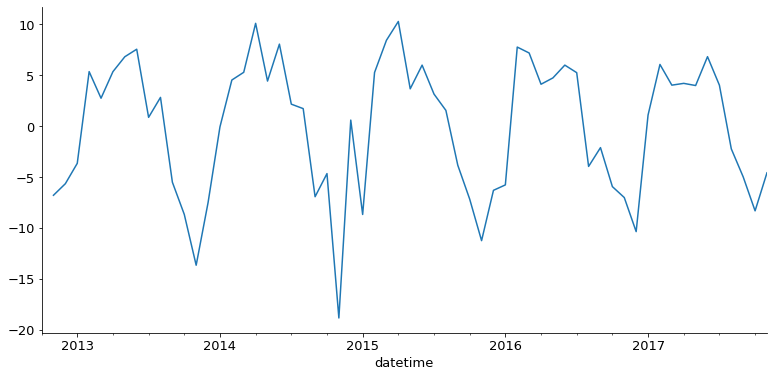

In [11]:
s.resample('M').mean().diff().plot()

Note that this looks pretty similar to plotting the monthly average temperature over time. However, note the units on the y-axis. This is now *change* in temperature from one month to the next.

We could visualize the difference in temperature from each day in the previous year by resampling to the day and using a diff of 365:

<AxesSubplot:xlabel='datetime'>

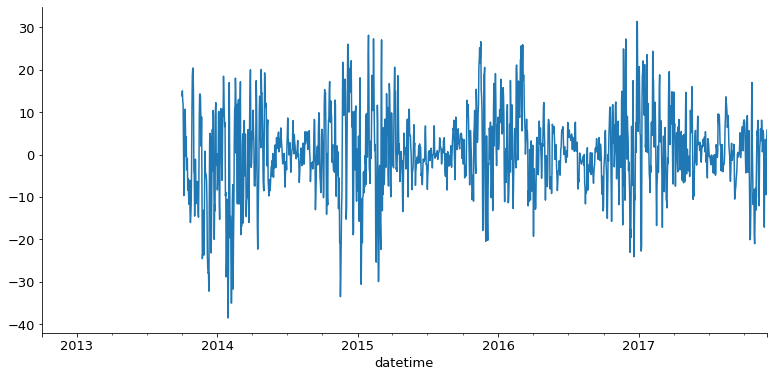

In [12]:
s.resample('D').mean().diff(365).plot()

Or we could look at the difference between each month and the same month the previous year by resampling to the month and taking a diff of 12:

<AxesSubplot:xlabel='datetime'>

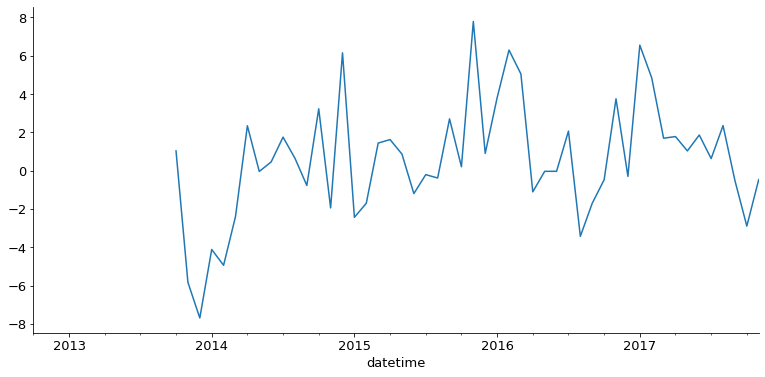

In [13]:
s.resample('M').mean().diff(12).plot()

### Shift

`.shift` is very similar to `.diff`, but `.shift` moves the values up by a certain amount as opposed to taking the difference:

In [14]:
df = pd.DataFrame(dict(x=[1, 2, 5, 0, 12]))
df

,x
0,1
1,2
2,5
3,0
4,12


In [15]:
df['x.shift()'] = df.x.shift()
df['x.shift(2)'] = df.x.shift(2)
df

,x,x.shift(),x.shift(2)
0,1,NaN,NaN
1,2,1.0,NaN
2,5,2.0,1.0
3,0,5.0,2.0
4,12,0.0,5.0


We could use `.shift` to overlay the temperature for the same month in hte previous year:

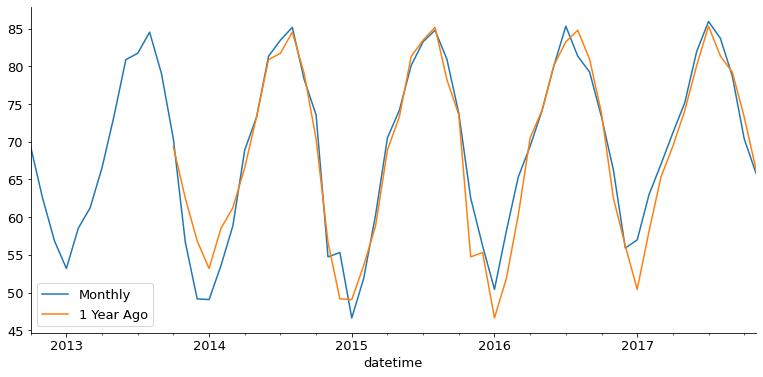

In [16]:
ax = s.resample('M').mean().plot(label='Monthly')
s.resample('M').mean().shift(12).plot(label='1 Year Ago', ax=ax)
ax.legend()

First we resample to the month and then do a shift of 12 to move each data point forward one year.

#### Customizing Ticks

There are a number of ways we can customize datetime axes using matplotlib:

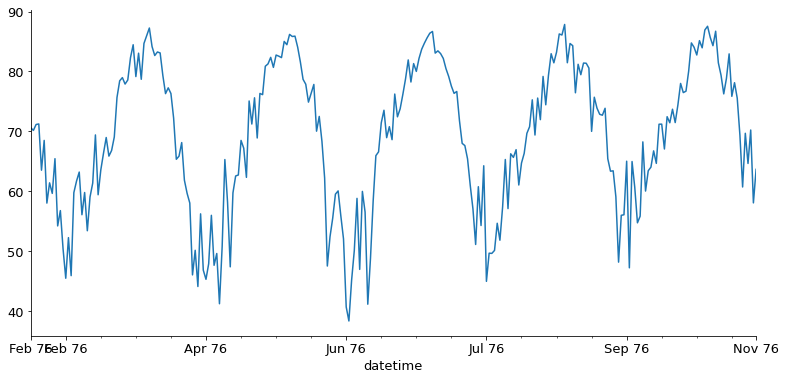

In [17]:
# Using a major formatter:
ax = s.resample('W').mean().plot()
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %y'))

[Text(0, 0, 'January'),
 Text(1, 0, 'February'),
 Text(2, 0, 'March'),
 Text(3, 0, 'April'),
 Text(4, 0, 'May'),
 Text(5, 0, 'June'),
 Text(6, 0, 'July'),
 Text(7, 0, 'August'),
 Text(8, 0, 'September'),
 Text(9, 0, 'October'),
 Text(10, 0, 'November'),
 Text(11, 0, 'December')]

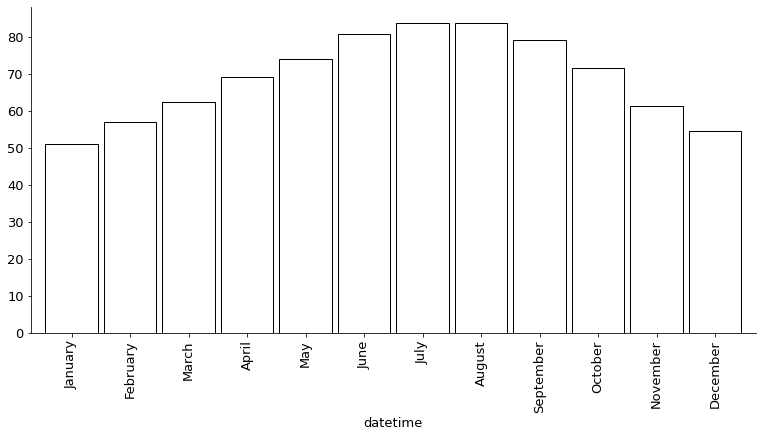

In [18]:
# Here we include the month number when grouping by month so that the months appear in the correct order in our visualization.
ax = s.groupby(s.index.strftime('%m-%B')).mean().plot.bar(width=.9, ec='black', fc='white')
# The next two lines basically "slice off" the number prefix of the month labels.
labels = ax.get_xticklabels()
ax.set_xticklabels([l.get_text()[3:] for l in labels])

## Identifying Seasonality and Trend

- **trend**: long term increase or decrease in the data
- **seasonality**: cyclic pattern of a fixed frequency

### Seasonality

A **lag plot** is a scatter plot of the value at a time against the value at the same time time plus some value, k.

For example, we could plot the correlation between the temperature one day and the temperature the next.

<AxesSubplot:xlabel='t', ylabel='t + 1'>

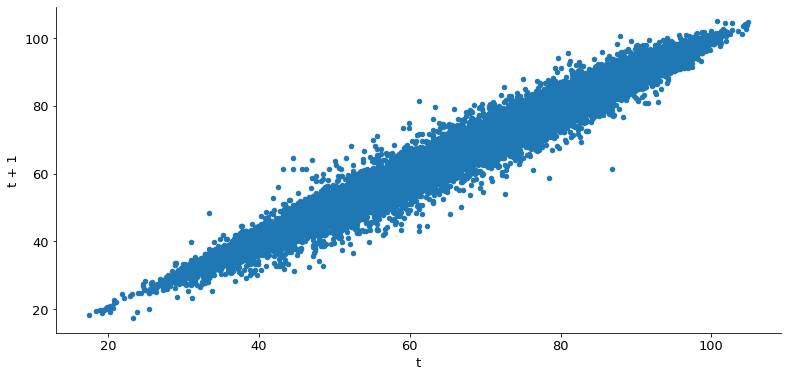

In [19]:
# We concatenate the series with itself shifted by 1 and then make a scatter plot of the two columns
pd.concat([s.rename('t'), s.shift().rename('t + 1')], axis=1).plot.scatter(y='t + 1', x='t')

Each point represents the temperature for one day on the x-axis, and the temperature for the next day on the y-axis.

The correlation between each day and the next day is pretty high.

Maybe less so for a day and the same day next week.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 7)'>

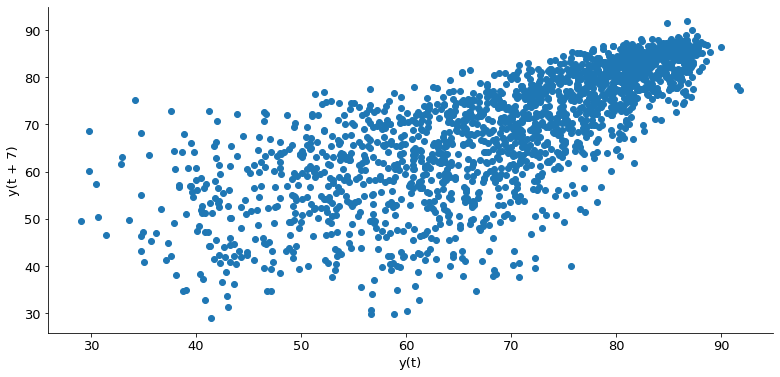

In [20]:
# note here we are using a pandas built-in to make our lag plot
pd.plotting.lag_plot(s.resample('D').mean(), 7)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

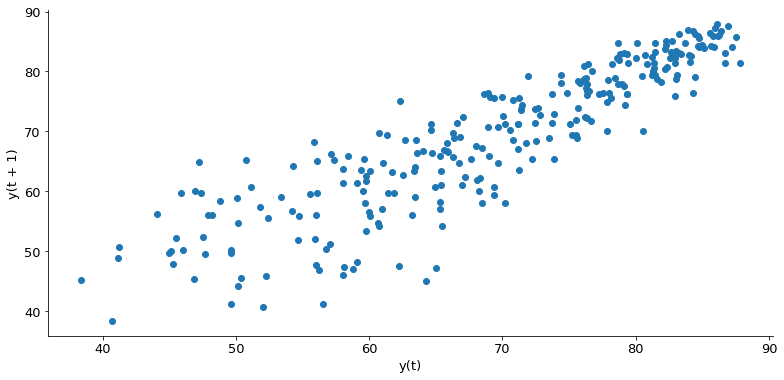

In [21]:
# We could also look at weeks instead of days
pd.plotting.lag_plot(s.resample('W').mean(), 1)

What's the correlation between each day and the same day the next year? Half year?

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 365)'>

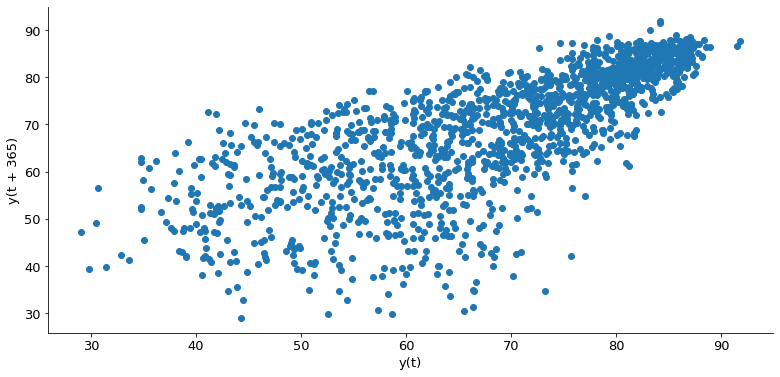

In [22]:
pd.plotting.lag_plot(s.resample('D').mean(), 365)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 182)'>

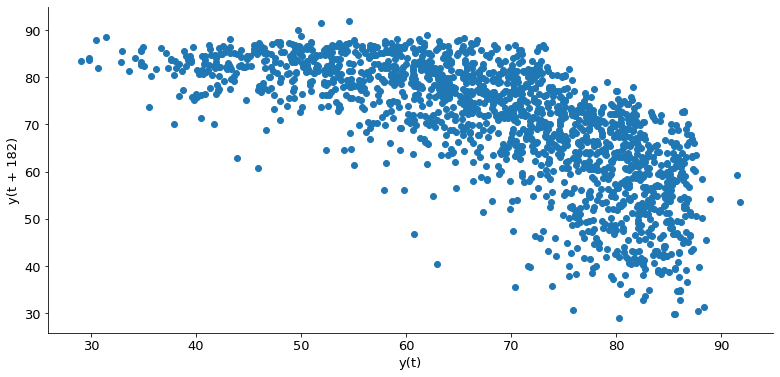

In [23]:
pd.plotting.lag_plot(s.resample('D').mean(), 182)

In [24]:
def correlation(s, lag):
    return pd.concat([s, s.shift(lag)], axis=1).dropna().corr().iloc[0, 1]

In [25]:
correlation(s.resample('D').mean(), 1)

0.9194017403999013

In [26]:
correlation(s.resample('D').mean(), 2)

0.8261401737244084

In [27]:
correlation(s.resample('D').mean(), 3)

0.7808360154795556

This brings us to the concept of **autocorrelation**. Autocorrelation is a series correlation with itself, at various different lag values.

In [28]:
# Here we construct a series with index being each number from 1 to 365, and the values being the
# autocorrelation for that value of lag
autocorr = pd.Series({lag: correlation(s.resample('D').mean(), lag) for lag in range(1, 365)})
autocorr

1      0.919402
2      0.826140
3      0.780836
4      0.769254
5      0.762207
         ...   
360    0.732681
361    0.739846
362    0.745104
363    0.745666
364    0.748745
Length: 364, dtype: float64

<AxesSubplot:>

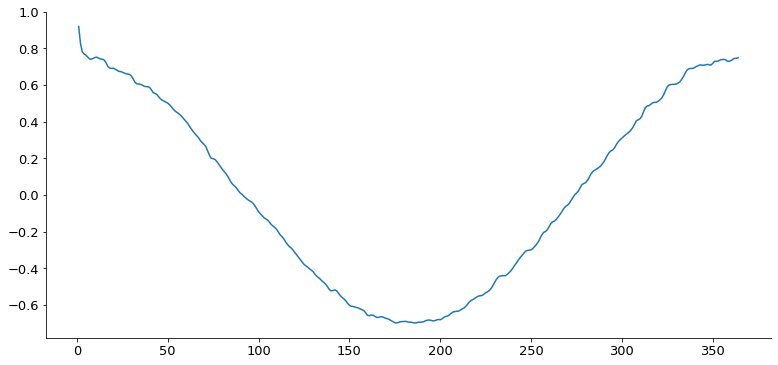

In [29]:
autocorr.plot()

This is a common visualization to use to identify seasonality, and pandas has a built in plotting function for it as well:

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

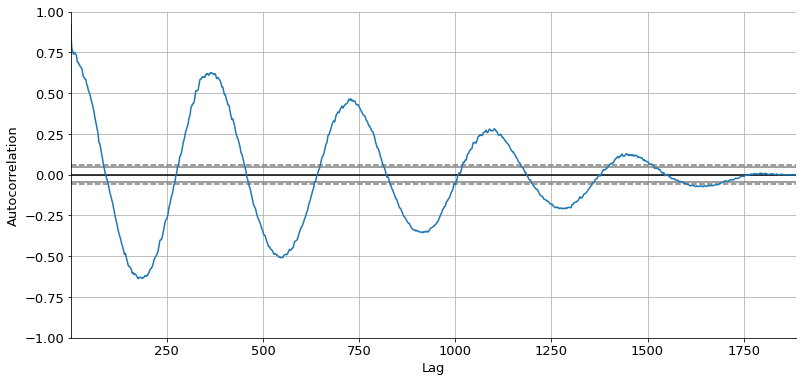

In [30]:
pd.plotting.autocorrelation_plot(s.resample('D').mean())

Note:

- The x axis is the value for laga
- The y axis is the correlation for that value of lag
- peaks indicate where the seasonal pattern repeats (each year / half year)
- decreasing peaks over time mean that correlation between this time this next year is stronger than the correlation between this time 2 years from now
- If the peaks fall within the horizontal lines, the observed pattern could be simply random noise. This is clearly **not** the case in the example above.

Remember, our choice of time units is somewhat arbitrary:

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

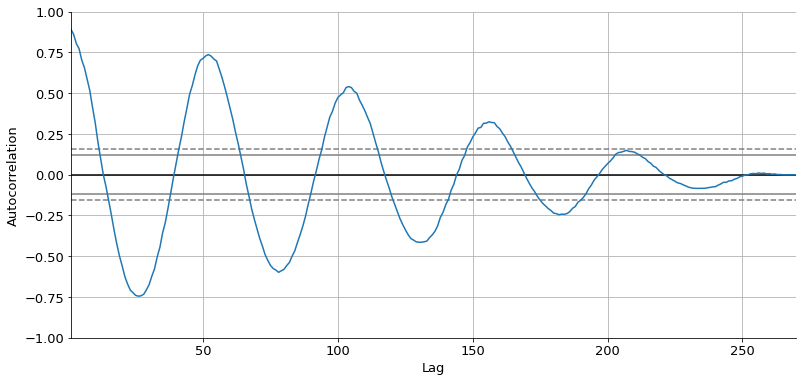

In [31]:
pd.plotting.autocorrelation_plot(s.resample('W').mean())

Notice in this dataset we also have hourly seasonality. Let's take a look at february 2013 as an example:

<AxesSubplot:xlabel='datetime'>

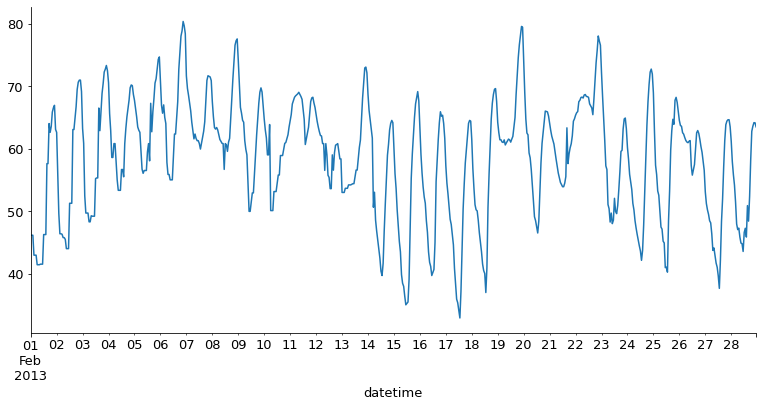

In [32]:
hourly = s['2013-02-01':'2013-02-28'].resample('H').mean()
hourly.plot()

We could view the autocorrelation plot for this hourly data as well:

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

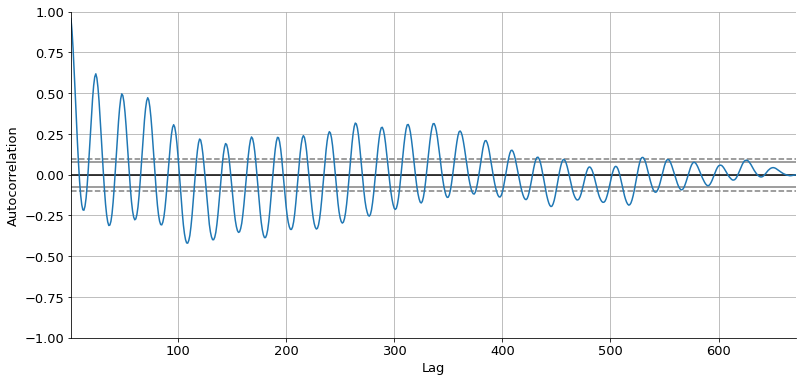

In [33]:
pd.plotting.autocorrelation_plot(hourly)

### Trend

There are several techniques and visualizations we can use to identify the long term upwards or downwards movement, that is, the trend, in our time series data.

To iullustrate this we'll use a dataset that we know has a longterm upwards trend:

<AxesSubplot:xlabel='Date'>

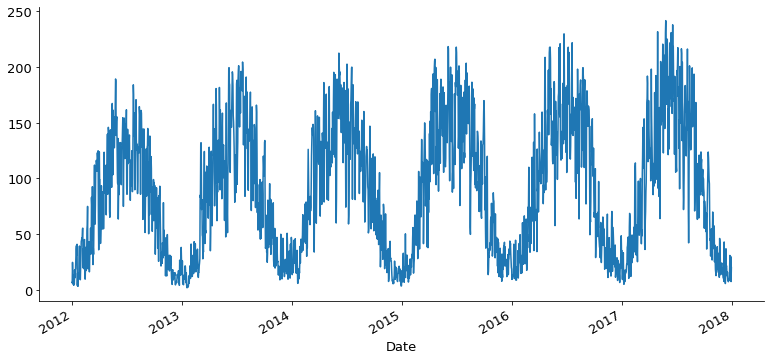

In [34]:
url = 'https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
df = pd.read_csv(url, index_col='Date', parse_dates=True)
s = df.Solar.dropna()
s.plot()

A **seasonal plot** shows each year as a seperate line:

<AxesSubplot:xlabel='Date'>

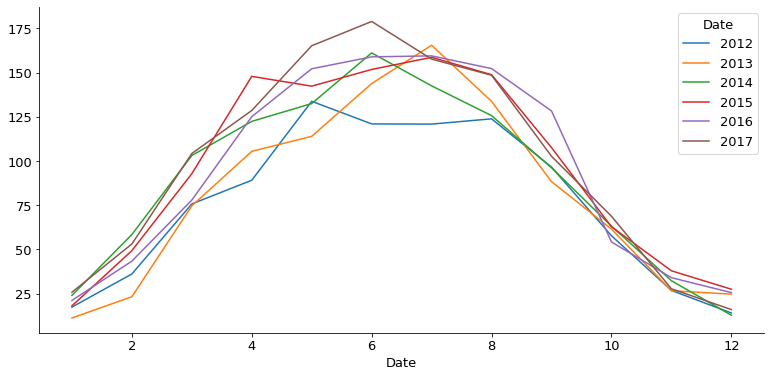

In [35]:
s.groupby([s.index.year, s.index.month]).mean().unstack(0).plot()

A **seasonal subseries plot** shows the year-over-year trend within each month:

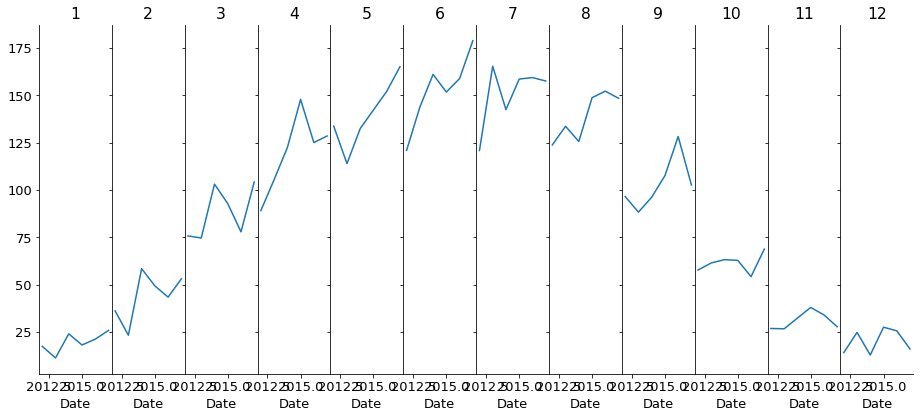

In [36]:
fig, axs = plt.subplots(1, 12, sharex=True, sharey=True)
for ax, (month, x) in zip(axs, s.groupby([s.index.year, s.index.month]).mean().unstack().iteritems()):
    x.plot(ax=ax, title=month)
fig.tight_layout()
fig.subplots_adjust(wspace=0)

## Seasonal Decomposition

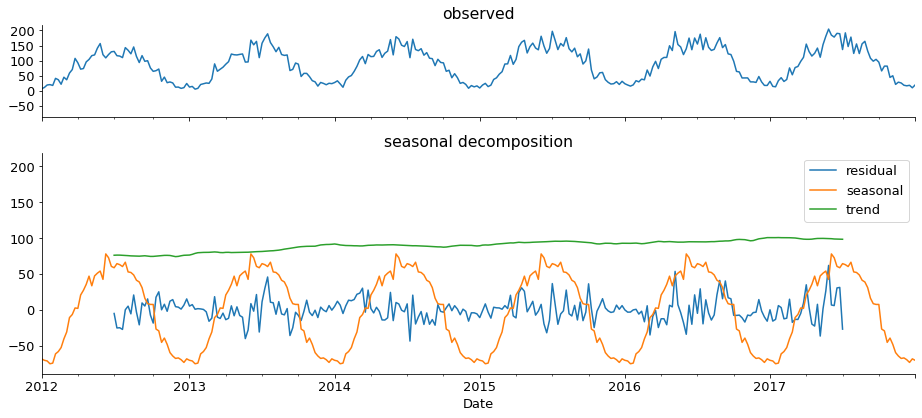

In [37]:
import statsmodels.api as sm

s = s.resample('W').mean()

# url = 'https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
# df = pd.read_csv(url, index_col='Date', parse_dates=True)
# s = df.Solar.dropna().resample('W').mean().ffill()

result = sm.tsa.seasonal_decompose(s, model='additive')
result = pd.DataFrame(dict(
    observed=result.observed,
    residual=result.resid,
    seasonal=result.seasonal,
    trend=result.trend
))
gs = plt.GridSpec(3, 1)
fig = plt.figure()
ax1 = fig.add_subplot(gs[1:])
ax2 = fig.add_subplot(gs[0], sharex=ax1, sharey=ax1)
result.iloc[:, 1:].plot(ax=ax1, title='seasonal decomposition')
result.observed.plot(ax=ax2, title='observed')
fig.tight_layout()

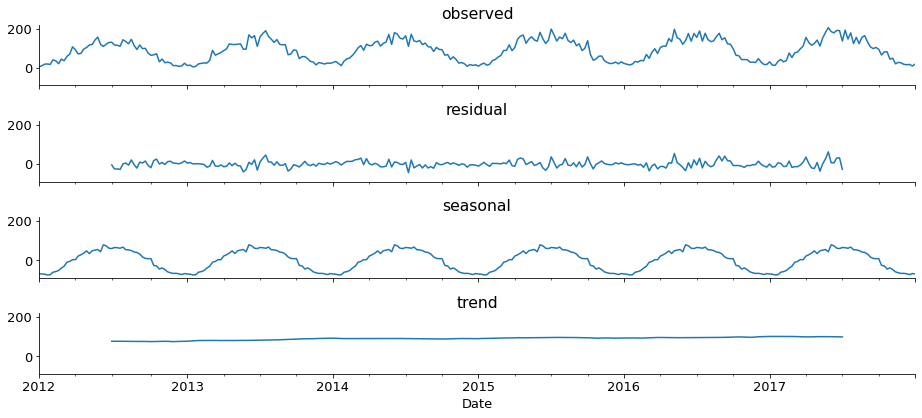

In [38]:
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)
for ax, (col, x) in zip(axs, result.iteritems()):
    x.plot(ax=ax, title=col)
fig.tight_layout()

What do these look like with synthetic data?

In [39]:
np.random.seed(123)
n = 365 * 4
idx = pd.date_range('2016', freq='D', periods=n)
df = pd.DataFrame({
    'trend': pd.Series(np.linspace(0, 2, n)),
    'seasonal': pd.Series(np.sin(np.linspace(0, 8*np.pi, n))),
    'noise': np.random.normal(1, .5, n)
}).set_index(idx)
df['combined'] = df.trend + df.seasonal + df.noise

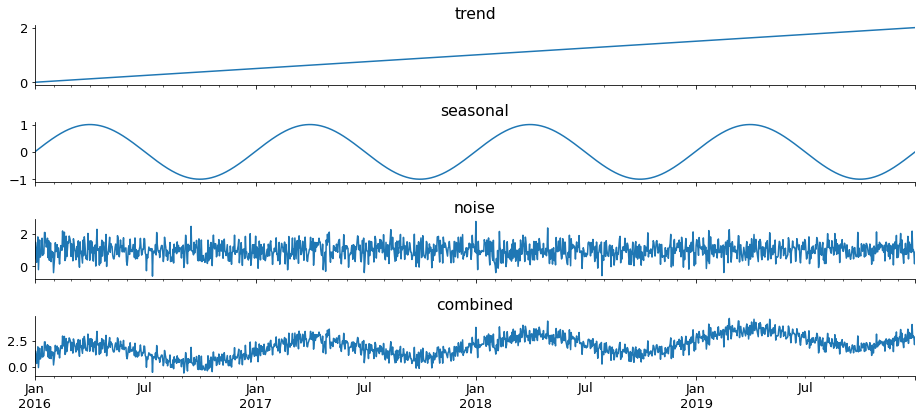

In [40]:
fig, axs = plt.subplots(4, 1, sharex=True)
for ax, (col, s) in zip(axs, df.iteritems()):
    s.plot(ax=ax, title=col)
fig.tight_layout()

What do our various visuals look like with this data?

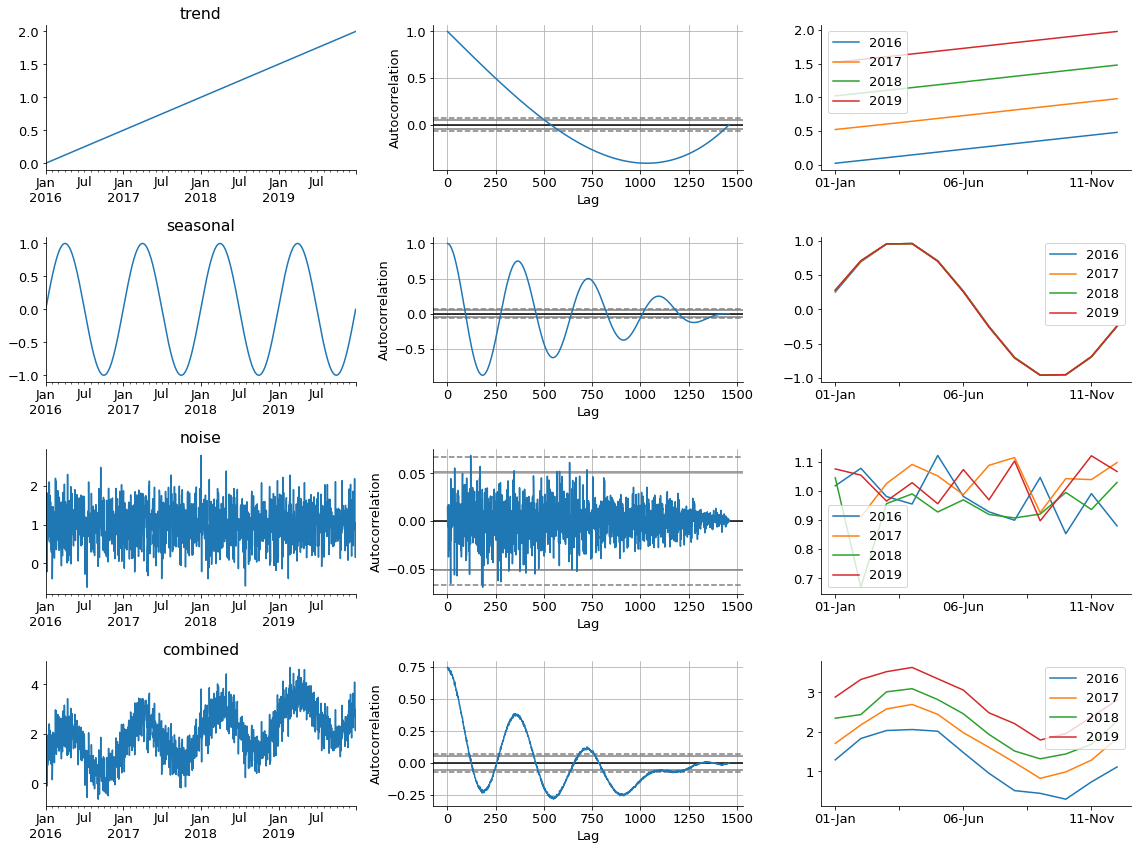

In [41]:
fig, axs = plt.subplots(4, 3, figsize=(4 * 4, 3 * 4))
for (ax1, ax2, ax3), (col, s) in zip(axs, df.iteritems()):
    s.plot(ax=ax1, title=col)
    pd.plotting.autocorrelation_plot(s, ax=ax2)
    s.groupby([s.index.year, s.index.strftime("%m-%b")]).mean().unstack(0).plot(ax=ax3)
fig.tight_layout()

Here each row represents one aspect of the seasonal decomposition and each column is a a different visualization (plotted overtime, autocorrelation, and a seasonal plot) of that aspect.